# Soy Future Market Analysis Report

## Market Info
#### Symbol Convention
[Base Symbol]+[Month Code]+[Year]

- For example, ```ZSQ25``` is the Chicago soybean future with expiration in September 2025.
- ```ZM=F``` refers to the **nearest to expiration** Chicago soy meal futures contract. For example, from March to April, the ```ZM=F``` tracks the May futures ```ZMK```.

#### Quick Summary
- Like wheat, soybeans and sunflower seeds aren't generally used or consumed directly, but require further processing. Unlike wheat, both soy and sunflower have applications for other food-production chains; soy is a valuable protein source for livestock feed, and both soy and sunflower oil are major vegetable fats used in food, food products, and industrial applications.

| Commodity Name     | Symbol | Key Growing Regions    | Primary Uses                       | Planting Season | Harvest Season | Vulnerable to                              | Expiry Month                           |
|--------------------|--------|------------------------|------------------------------------|-----------------|----------------|--------------------------------------------|----------------------------------------|
| **Whole Soybeans** | `ZS`   | Central U.S. (Plains)  | Edamame, soy sauce, meat substitutes           | Mar-Apr         | Sep-Oct        | leaf disease, cold damage & drought        | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Oil**    | `ZL`   | N/A  | Vegetable oil, food additives, ink, paint     | N/A             | N/A        | N/A            | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |
| **Soybean Meal**   | `ZM`   | N/A | Protein isolate, tofu, soy milk                     | N/A             | N/A        | N/A | Jan, Mar, May, Jul, Aug, Sep, Oct, Dec (F, H, K, N, Q, U, X) |

#### Geopolitical & Export Demand
- The U.S. is the world's second largest producer of soy, after Brazil.
- China is the largest importer from the U.S., for ~$20Bn/year as of 2025.
- Mexico and the EU also import ~$2Bn/year of soy.
- Large stocks of, production capacities of, and agro-industrial demand for soy all mean that the soy futures market is highly liquid.

#### Last trading day
- The business day before the 15th calendar day of the contract month. Usually, it would be the 14th of that day at 1:20pm CT.
- The soy is already in the warehouse before the expiration date. Once the ownership is transferred to the long trader, the long trader must pay the storage fees.
- After the last trading day, the buyer of the contract must take delivery. This will incur daily warehouse fee, handling fees and delivery fees.
- Most trades will close their positions before the First Notice day, or the last trading day.

In [1]:
# Lots of things to import

import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
from datetime import datetime
import sys
import json

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import seaborn as sns

In [22]:
# Reading data from file
ZS_data = pd.read_csv('ZS-data.csv', parse_dates=['Date'])
ZL_data = pd.read_csv('ZL-data.csv', parse_dates=['Date'])
ZM_data = pd.read_csv('ZM-data.csv', parse_dates=['Date'])

ZS_new = pd.read_csv('ZS-new.csv', parse_dates=['Date'])
ZL_new = pd.read_csv('ZL-new.csv', parse_dates=['Date'])
ZM_new = pd.read_csv('ZM-new.csv', parse_dates=['Date'])

dfs = [ZS_data, ZL_data, ZM_data, ZS_new, ZL_new, ZM_new]

# Parse dates and break down into Day/Month/Year/Day of Year
for d in dfs:
    d['Date'] = pd.to_datetime(d['Date'], utc=True)
    d.set_index('Date', inplace=True)
    d['Year'] = d.index.year
    d['Month'] = d.index.month
    d['Day'] = d.index.day
    d['Day_Of_Year'] = d.index.dayofyear

# ZS_data['Date'] = pd.to_datetime(ZS_data['Date'], utc=True)
# ZL_data['Date'] = pd.to_datetime(ZL_data['Date'], utc=True)
# ZM_data['Date'] = pd.to_datetime(ZM_data['Date'], utc=True)

# ZS_data.set_index('Date', inplace=True)
# ZL_data.set_index('Date', inplace=True)
# ZM_data.set_index('Date', inplace=True)

# ZS_data['Year'] = ZS_data.index.year
# ZS_data['Month'] = ZS_data.index.month
# ZS_data['Day'] = ZS_data.index.day
# ZS_data['Day_Of_Year'] = ZS_data.index.dayofyear
# ZL_data['Year'] = ZL_data.index.year
# ZL_data['Month'] = ZL_data.index.month
# ZL_data['Day'] = ZL_data.index.day
# ZL_data['Day_Of_Year'] = ZL_data.index.dayofyear
# ZM_data['Year'] = ZM_data.index.year
# ZM_data['Month'] = ZM_data.index.month
# ZM_data['Day'] = ZM_data.index.day
# ZM_data['Day_Of_Year'] = ZM_data.index.dayofyear

# Log return
ZS_data['Log Return'] = np.log(ZS_data['Close']) - np.log(ZS_data['Close'].shift(1))

# Rename to separate after concatenation
ZS_dict = {}
ZL_dict = {}
ZM_dict = {}

for col in ZS_data.columns:
    # ZS_dict[col] = 'ZS ' + col
    ZL_dict[col] = 'ZL ' + col
    ZM_dict[col] = 'ZM ' + col

ZS_data.rename(columns=ZS_dict, inplace=True)
ZL_data.rename(columns=ZL_dict, inplace=True)
ZM_data.rename(columns=ZM_dict, inplace=True)
ZL_new.rename(columns=ZL_dict, inplace=True)
ZM_new.rename(columns=ZM_dict, inplace=True)


# The below split might still be bad but should be usable...

# Unnecessary - we already import data as split by 2025-01-01
# splitting_point = '2025-01-01'
# feature_cols = ['Close', 'Log Return']

ZS_train = ZS_data
ZS_test = ZS_new
# train_indices = ZS_train.index
# test_indices = ZS_test.index

ZL_train = ZL_data #.loc[ZL_data.index.isin(train_indices)]
ZL_test = ZL_new #.loc[ZL_data.index.isin(test_indices)]
ZM_train = ZM_data #.loc[ZM_data.index.isin(train_indices)]
ZM_test = ZM_new #.loc[ZM_data.index.isin(test_indices)]

ZZ_data = pd.concat([ZL_data, ZM_data], axis=1)
ZZ_train = ZZ_data #.loc[ZZ_data.index.isin(train_indices)]
ZZ_test =  pd.concat([ZL_new, ZM_new], axis=1) #ZZ_data.loc[ZZ_data.index.isin(test_indices)]

ZW_data = pd.concat([ZL_data, ZM_data, ZS_data], axis=1)
ZW_train = ZW_data #.loc[ZW_data.index.isin(train_indices)]
ZW_test = pd.concat([ZL_new, ZM_new, ZS_new], axis=1) #ZW_data.loc[ZW_data.index.isin(test_indices)]

# For time-series padding - sometimes we need to give the test datapoints some history
ZZ_all = pd.concat([ZZ_train, ZZ_test])
ZW_all = pd.concat([ZW_train, ZW_test])
HIST_LENGTH = ZZ_train.shape[0]
NEW_LENGTH = ZW_all.shape[0] - HIST_LENGTH

# Log return
ZW_all['Log Return'] = np.log(ZW_all['Close']) - np.log(ZW_all['Close'].shift(1))
ZW_test['Log Return'] = np.log(ZW_test['Close']) - np.log(ZW_test['Close'].shift(1))

# Initial Fits
Our EDA and desiderata mean we should likely be trying to predict daily log-returns of closing prices, so we add a feature of that form to ZS. They also point us towards a few possibilities for a predictive fit, with a few major possibilities:
* Some kind of time-series linear fit, like an AR with lags 1 and 10 provided by the EDA
* An XGBoost model, to see if a gold-standard nonparametric model can do well
* A weather/mood model, to see whether the weather in Chicago specifically (where the major trading floors and their surrounding businesses are) has some systematic effect on pricing 
* An OLS linear fit on *untransformed pricing data* for some horizon (like 30 days) to predict the *log return*
  

## Linear Lag Model
During EDA, partial autocorrelation on interday log returns turned up two potential correlations: a large one with a one-day lag, and one with a ten-day lag whose coefficient was small but outside null-hypothesis $2 \sigma$ confidence intervals. A test fit was thus indicated to try to turn up potential market signal.

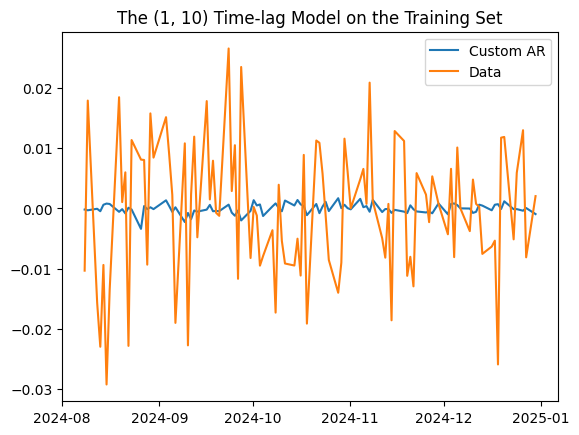

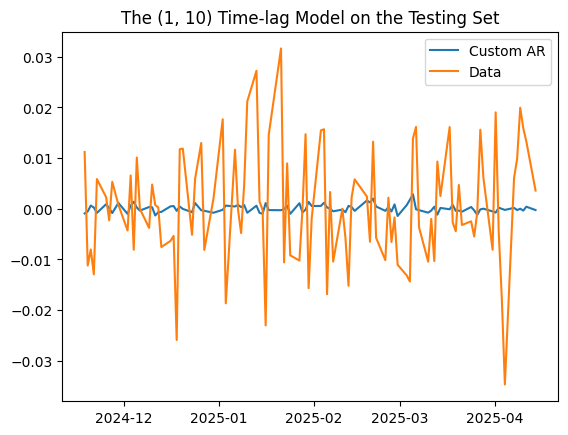

Mean Squared Error: 0.000134
R² Score: -0.007991


In [9]:
# Linear Lag model
def X_y_for_lags(ts, num_lags):
    '''
    Inputs
        ts: A numpy array of size (n,) representing a time series
        num_lags: The number of lags to include in the resulting design matrix

    Outputs
        X: A numpy array of size (n - num_lags, num_lags). 
            The first column is lag 1, second column is lag 2, etc 
        y: The time series starting at entry num_lags
    '''
    ts = ts.astype(float)
    n = len(ts)
    X = np.zeros(shape=(n - num_lags, num_lags))
    for i in range(num_lags):
        X[:, i] = ts[num_lags - i - 1 : n - i - 1]
    y = ts[num_lags:]
    return X, y

# holdout
ZW_tt = ZW_train[1:-20]

# Fit from (P)ACF - linear time-series in terms of x_1 and x_10
design_matrix, targets = X_y_for_lags(ZW_tt['Log Return'], 10)
soymodel = LinearRegression()
soymodel_preds = []

design_matrix_test, targets_test = X_y_for_lags(ZW_all['Log Return'], 10)
soymodel_test_preds = []

for i in range(-100, 0):
    X_tt, y_tt = design_matrix[:i], targets[:i]
    X_ho, y_ho = design_matrix[[i]], targets.iloc[i]

    X_tt = X_tt[:,[0, 9]]
    X_ho = X_ho[:,[0, 9]]

    soymodel.fit(X_tt, y_tt)
    soymodel_preds.append(soymodel.predict(X_ho)[0])

for j in range(-10, -HIST_LENGTH, -1):
    X_v, y_v = design_matrix_test[j:], targets_test[j:]
    X_v = X_v[1:,[0, 9]]
    y_v = y_v[1:]

    if np.isnan(X_v).any():
        print(j, np.argwhere(np.isnan(X_v)))

    if not np.isnan(X_v).any():
        soymodel.fit(X_v, y_v)
        # print(soymodel.coef_)
        soymodel_test_preds.append(soymodel.predict(X_v)[0])

# print(soymodel.coef_, soymodel.intercept_)
plt.title('The (1, 10) Time-lag Model on the Training Set')
plt.plot(ZW_train['Log Return'].index[-100:], soymodel_preds[-100:], label = 'Custom AR')
plt.plot(ZW_train['Log Return'].index[-100:], ZW_train['Log Return'].iloc[-100:], label = 'Data')
plt.legend()
plt.show()  # It's... not actually all that good, sadly.

plt.title('The (1, 10) Time-lag Model on the Testing Set')
plt.plot(ZW_all['Log Return'].index[-100:], soymodel_test_preds[-100:], label = 'Custom AR')
plt.plot(ZW_all['Log Return'].index[-100:], ZW_all['Log Return'].iloc[-100:], label = 'Data')
plt.legend()
plt.show()  # Still not very good.

mse = mean_squared_error(ZW_all['Log Return'].iloc[-100:], soymodel_test_preds[-100:])
r2 = r2_score(ZW_all['Log Return'].iloc[-100:], soymodel_test_preds[-100:])
print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.6f}")

## XGBoost Model
On the grounds that interday log-returns might be weak-learnable and thus strong-learnable by even sone fairly simple machine learning system, the use of XGBoost for a test fit was indicated.

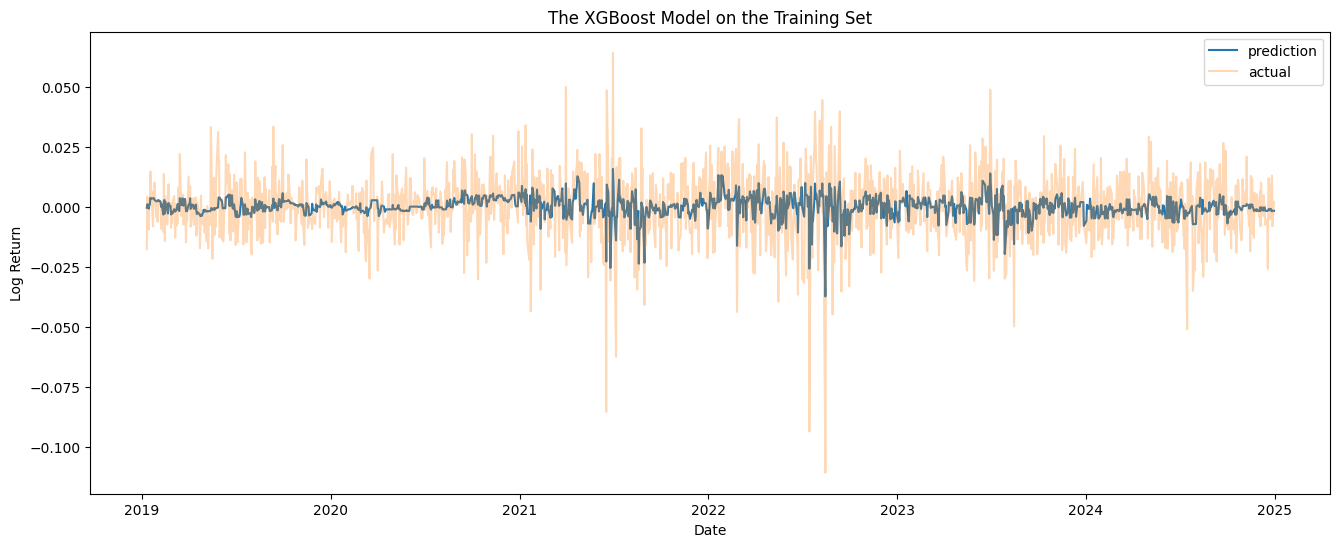

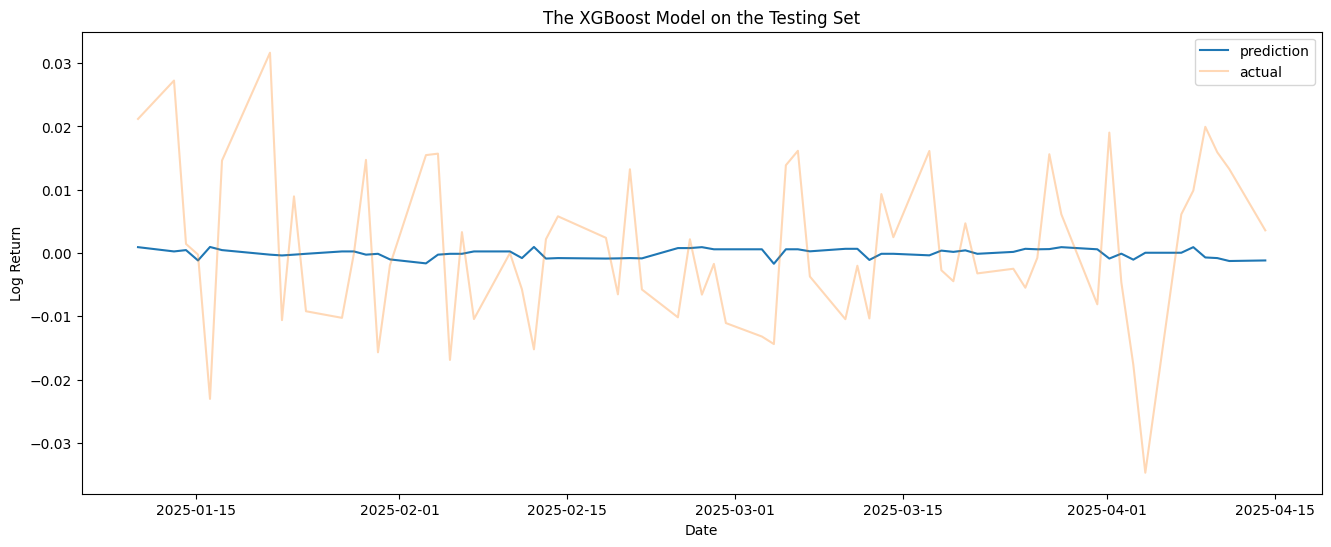

Mean Squared Error (Train): 0.000110
R² Score (Train): 0.138563
Mean Squared Error (Test): 0.000160
R² Score (Test): -0.020416


In [17]:

# XG Boost model w/o regularization - how good of a score does it get on the training data?
tscv = TimeSeriesSplit(n_splits=10)
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=14,
    eval_metric=r2_score,
#    device='cuda',
    reg_alpha=0.1,
    reg_lambda=0.1,
#    gamma=0.1,
    # early_stopping_rounds=16,
#    min_child_weight=5,
#    subsample=0.7,
#    colsample_bytree=0.7,
)

# ZW_train.info()
# ZW_train.head
ZW_train = ZW_train.iloc[1:]
ZW_test = ZW_test.iloc[1:]

cv_scores = cross_val_score(xgb_model, ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return'], cv=tscv, scoring='r2')
# print(f'Cross-validation R2 scores: {cv_scores}')  # Convert to positive MAE values
# print(f'Average R2: {np.mean(cv_scores):.4f}')

xgb_model.fit(ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return'], verbose=False,eval_set=[(ZW_train[['ZL Close', 'ZM Close', 'Close']], ZW_train['Log Return']), (ZW_test[['ZL Close', 'ZM Close', 'Close']], ZW_test['Log Return'])])
y_pred = xgb_model.predict(ZW_test[['ZL Close', 'ZM Close', 'Close']])

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the Training Set')
sns.lineplot(x=ZW_train['Log Return'].index, y=xgb_model.predict(ZW_train[['ZL Close', 'ZM Close', 'Close']]), label='prediction')
sns.lineplot(x=ZW_train['Log Return'].index, y=ZW_train['Log Return'], label='actual', alpha = 0.3)
plt.show()

plt.figure(figsize=(16, 6))
plt.title('The XGBoost Model on the Testing Set')
sns.lineplot(x=ZW_test['Log Return'].index, y=y_pred, label='prediction')
sns.lineplot(x=ZW_test['Log Return'].index, y=ZW_test['Log Return'], label='actual', alpha = 0.3)
plt.show()

# plt.figure(figsize=(16, 6))
# plt.plot(range(1,len(xgb_model.evals_result()['validation_0']['rmse'])+1), 
#          xgb_model.evals_result()['validation_0']['rmse'])
# plt.scatter([range(1,len(xgb_model.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_model.evals_result()['validation_0']['rmse'])]], 
#             [np.min(xgb_model.evals_result()['validation_0']['rmse'])], c='k')
# plt.text(range(1,len(xgb_model.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_model.evals_result()['validation_0']['rmse'])], 
#          np.min(xgb_model.evals_result()['validation_0']['rmse'])-.05, "Min.", fontsize=10)

# plt.title("Validation Error", fontsize=14)
# plt.xlabel("Number of Weak Learners", fontsize=12)
# plt.ylabel("RMSE", fontsize=12)

# plt.yticks(fontsize=10)
# plt.xticks(fontsize=10)

# plt.show()
y_train = xgb_model.predict(ZW_train[['ZL Close', 'ZM Close', 'Close']])
mse = mean_squared_error(ZW_train['Log Return'].iloc[-100:], y_train[-100:])
r2 = r2_score(ZW_train['Log Return'].iloc[-100:], y_train[-100:])
print(f"Mean Squared Error (Train): {mse:.6f}")
print(f"R² Score (Train): {r2:.6f}")

mse = mean_squared_error(ZW_test['Log Return'].iloc[-100:], y_pred[-100:])
r2 = r2_score(ZW_test['Log Return'].iloc[-100:], y_pred[-100:])
print(f"Mean Squared Error (Test): {mse:.6f}")
print(f"R² Score (Test): {r2:.6f}")


## Weather-Mood Model
A conventional hypothesis trying to find market signal from weather might route through the direct effect of weather on crop yields and qualities, and thus on futures prices; however, our exploratory analysis of such effects on wheat, sugar, and oranges have already found relatively little signal. This should not be so surprising: since this is a natural idea, other analysts will have already found and exploited any signal thus derivable.

By contrast, a less conventional hypothesis might go looking for systematic miscalibration effects on the traders themselves: on warm dry days, a happy trader might overestimate the value of a commodity, whereas on a cold rainy day, a gloomier trader might systematically underestimate the same commodity.

Knowing that much of the trading volume on our commodities of interest occur on Chicago exchanges and are executed by traders physically located near Chicago, an exploration of the predictive strength of Cook County weather on log returns seems indicated. We thus add a categorical feature dependent on average temperature and precipitation.

In [20]:
# Weather import model - are (largely Chicago-based) traders notably rosier/gloomier in their outlook, dependent on the weather?

sys.path.insert(0, '..')
import src.data.weather_script as ws

start_date = '2020-01-01'
end_date = '2025-04-01'
url = "http://data.rcc-acis.org/MultiStnData"
params = {
        "county": 17031,  # Cook County
        # "sid": sid,  # Station ID
        "sdate": start_date,  # Start date
        "edate": end_date,  # End date
        # "date": date,
        
        "elems":["maxt","mint","avgt","pcpn","snow"],
        "output": "json"
    }
    
response = requests.post(url, json=params)
    
if response.status_code == 200:
    data = response.json()
    # return data
else:
    print("Error fetching data:", response.status_code, response.text)



# Are log returns lower if pcpn is high or avgt is far from 70 *F?

# Are log returns higher if pcpn is low and avgt is close to 70 *F?


## Baseline Model - Ordinary Least Squares Regression on Moving 30-Day Window
For a natural baseline model, an ordinary least squares regression of log-return as a function of the previous 30 days' worth of closing prices is a natural fit, and thus something to check here.  

Mean Squared Error: 0.000176
R² Score: 0.031988
Coefficients: [ 0.01626411  0.01419311 -0.02440268 -0.05752274 -0.02395782  0.02114414
 -0.00856813 -0.00891985  0.0053621   0.05953203 -0.01477276  0.05645101
  0.03460219 -0.0537279  -0.0114683  -0.00488831 -0.01474204 -0.00832268
  0.02264787  0.00908687  0.05873847  0.00568079 -0.00883722  0.02644178
 -0.05095116 -0.02156632  0.00054645  0.05678866 -0.00620085 -0.05142326]
Intercept: 5.270538098827347e-05


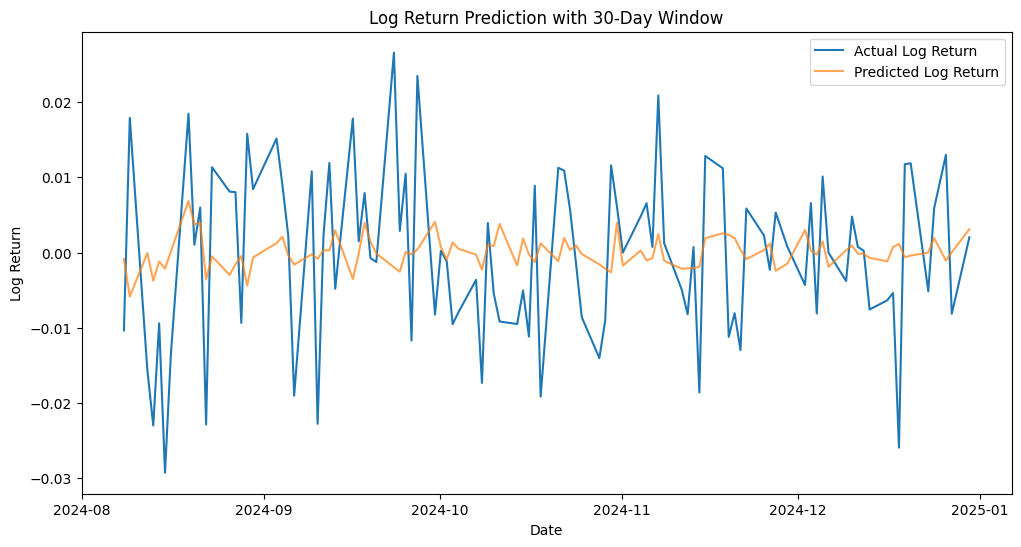

Mean Squared Error: 0.000102
R² Score: 0.346277
Coefficients: [ 6.45589758e-02 -1.70511355e-01 -2.74096984e-01  7.63470165e-05
 -9.98870608e-02 -4.73353004e-02  1.11824511e-01 -2.13828285e-02
  2.64958830e-01  9.17312551e-02  4.08698471e-02  2.38635210e-01
 -8.11086592e-02 -1.54081741e-01  1.08196400e-01 -2.03793452e-01
 -3.40881369e-02  4.84957444e-02 -8.51441097e-02 -1.86750270e-01
 -8.93928532e-02 -1.70327280e-01 -1.36682258e-01  1.35414877e-01
  7.41174072e-02  5.78194243e-02 -2.07855215e-02  1.82567026e-02
  2.75389739e-02 -2.03135422e-01]
Intercept: 0.0009039044915633646


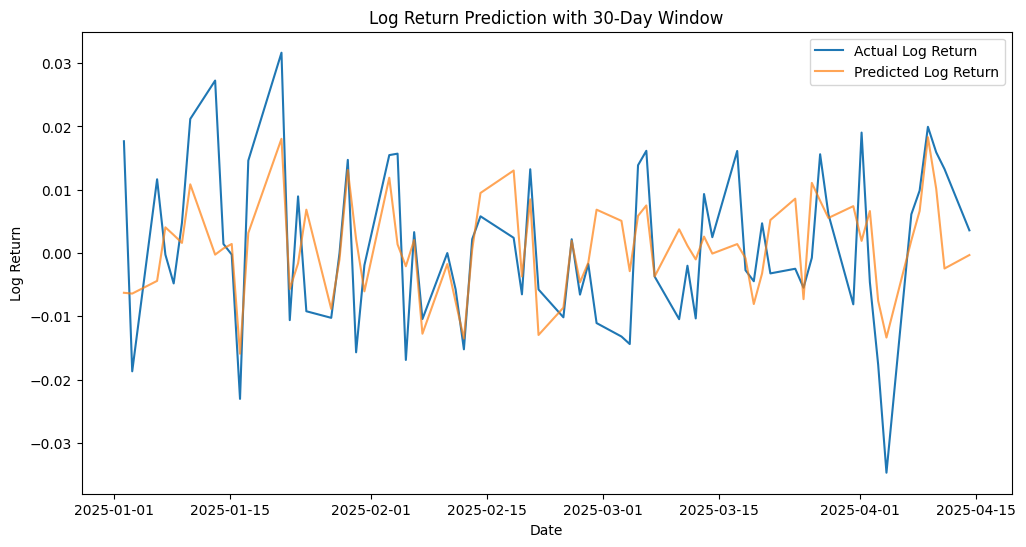

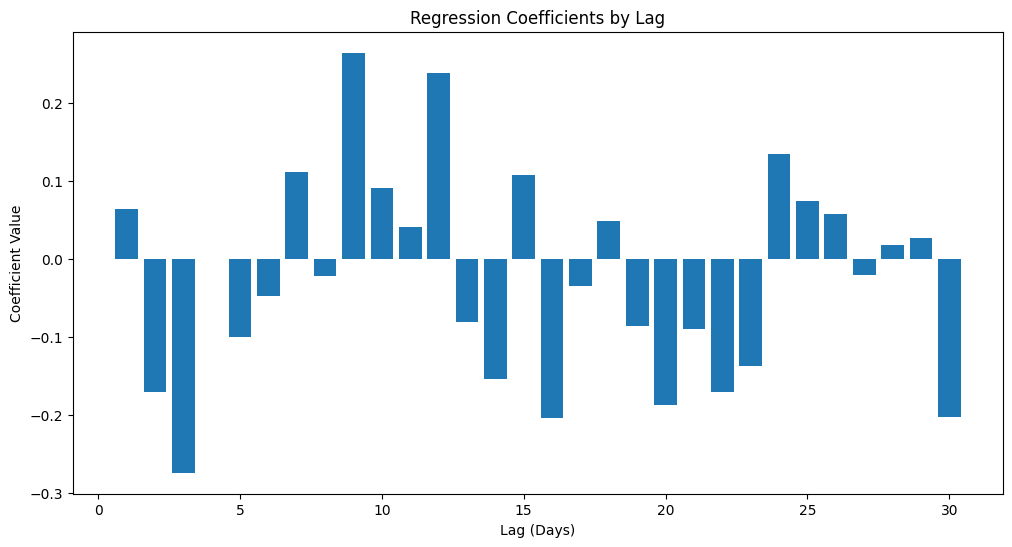

In [24]:
# OLS for log-return over untransformed closing price data
def lag_regression(df, target_col='Log Return', window_size=30):
    """
    Run a regression where the target variable on day n is predicted
    from the values of the same variable from days n-window_size to n-1.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with a column for target variable and date index
    target_col : str
        Column name of the target variable
    window_size : int
        Number of days to include in the window
        
    Returns:
    --------
    results_df : pandas DataFrame
        DataFrame containing predictions and model metrics
    """
    # Create a DataFrame to store results
    results = []
    
    # Create lag features
    data = df.copy()
    for i in range(1, window_size + 1):
        data[f'Lag_{i}'] = data[target_col].shift(i)
    
    # Drop rows with NaN values (first window_size rows)
    data = data.dropna()
    
    # Define features and target
    X = data[[f'Lag_{i}' for i in range(1, window_size + 1)]]
    y = data[target_col]
    
    # Fit the model
    model = LinearRegression()
    model.fit(X, y)
    
    # Make predictions
    data['Predicted'] = model.predict(X)
    data['Error'] = data[target_col] - data['Predicted']
    
    # Calculate metrics
    mse = mean_squared_error(y, data['Predicted'])
    r2 = r2_score(y, data['Predicted'])
    
    print(f"Mean Squared Error: {mse:.6f}")
    print(f"R² Score: {r2:.6f}")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    
    # Create results DataFrame
    results_df = data[[target_col, 'Predicted', 'Error']].copy()
    results_df.columns = ['Actual', 'Predicted', 'Error']
    
    return results_df, model

# Example usage
window_size = 30
prediction_results, model = lag_regression(ZW_train, target_col='Log Return', window_size=window_size)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(prediction_results.index[-100:], prediction_results['Actual'][-100:], label='Actual Log Return')
plt.plot(prediction_results.index[-100:], prediction_results['Predicted'][-100:], label='Predicted Log Return', alpha=0.7)
plt.title(f'Log Return Prediction with {window_size}-Day Window')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

prediction_results, model = lag_regression(ZW_all[-NEW_LENGTH-30:], target_col='Log Return')

plt.figure(figsize=(12, 6))
plt.plot(prediction_results.index[-100:], prediction_results['Actual'][-100:], label='Actual Log Return')
plt.plot(prediction_results.index[-100:], prediction_results['Predicted'][-100:], label='Predicted Log Return', alpha=0.7)
plt.title(f'Log Return Prediction with {window_size}-Day Window')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.bar(range(1, window_size + 1), model.coef_)
plt.title('Regression Coefficients by Lag')
plt.xlabel('Lag (Days)')
plt.ylabel('Coefficient Value')
plt.show()

# Summary
From scores, my best model was the baseline model

# Cross-Validation (To-Do)

In [ ]:
# Make a KFold object
# remember to set a random_state and set shuffle = True
num_splits = 5
num_models = 4
kfold = KFold(num_splits, shuffle=True, random_state=518)

# This array will hold the mse for each model and split

s = np.zeros((num_models, num_splits))

# set a split counter
i = 0

# loop through the kfold here
for train_index, test_index in kfold.split(ZS_train):
    # cv training set
    ZS_tt = ZS_train.iloc[train_index]
    
    # cv holdout set
    ZS_ho = ZS_train.iloc[test_index]
    
    # "Fit" mean and get holdout root mean squared error for the baseline model.
    # No need to use an sklearn function:  just get the mean.  
    # baseline_pred should be a numpy array with the same number of elements as ZS_ho

    baseline_pred = ZS_tt.median_house_value.mean()*np.ones(len(ZS_ho))
    rmses[0, i] = root_mean_squared_error(ZS_ho.median_house_value, baseline_pred)
    
    # Fit and get ho rmse for slr model
    slr = LinearRegression()
    slr.fit(ZS_tt[['median_income']], ZS_tt.median_house_value)
    rmses[1, i] = root_mean_squared_error(ZS_ho.median_house_value, slr.predict(ZS_ho[['median_income']]))
    
    ## Fit and get ho mse for mlr model
    mlr = LinearRegression()
    mlr.fit(ZS_tt[['median_income', 'households']], ZS_tt.median_house_value)
    rmses[2, i] = root_mean_squared_error(ZS_ho.median_house_value, mlr.predict(ZS_ho[['median_income', 'households']])) 
    
    ## Fit and get ho rmse for the spatial model
    knn = KNeighborsRegressor()
    knn.fit(ZS_tt[['latitude', 'longitude']], ZS_tt.median_house_value)
    rmses[3, i] = root_mean_squared_error(ZS_ho.median_house_value, knn.predict(ZS_ho[['latitude', 'longitude']]))
    
    i = i + 1